In [1]:
from pathlib import Path

data_file = lambda filename: Path().resolve().parent.joinpath(*['data', filename])
cache_file = lambda filename: Path().resolve().parent.joinpath(*['cache', filename])
figure_file = lambda filename: Path().resolve().parent.joinpath(*['figures', filename])

In [2]:
from google.cloud import bigquery
import pandas as pd
from tqdm import tqdm
from concurrent.futures import TimeoutError
import os
import numpy as np
import json

"""BIG QUERY FUNCTIONS"""

def client():
    """require a bigquery project and credentials, save in json in root main directory"""
    credsfile = Path().resolve().parent.joinpath('antiechochambers-1ba7f7f4c68e.json')
    return bigquery.Client.from_service_account_json(credsfile)

def jobConfig():
    config = bigquery.QueryJobConfig()
    config.query_parameters = (bigquery.ScalarQueryParameter('size', 'INT64', 10),)
    config.use_legacy_sql = False
    config.maximum_bytes_billed = int(5e9)
    
    return config

def run_job(query):
    print('Submitting query')
    j = client().query(query=query, job_config=jobConfig())
    with tqdm() as pbar:
        while True:
            try:
                j.result(timeout=1)
            except TimeoutError:                
                pbar.update(1)
            else:
                break
    return j

def unpack_results(j):
    print('Unpacking results')
    
    total = j.query_results().total_rows
    
    iterator = j.result()
    rows = []
    for row in tqdm(iterator, total=total):
        rows.append(row.values())
    
    columns = [c.name for c in iterator.schema]
    df = pd.DataFrame(rows, None, columns)
    
    return df


def fetchQuery(query):
    j = run_job(query)
    df = j.to_dataframe()
    
    return df

In [65]:
subreddit = "changemyview"
"""should create bot table to call on"""
query = f"""SELECT subreddit, author, COUNT(created_utc) as weight
            FROM `fh-bigquery.reddit_comments.2017_06`
            WHERE author in (SELECT author
                             FROM `aerobic-datum-126519.sms_18_sample_subreddits.mainSubInCounts`
                             WHERE (subreddit = '{subreddit}') AND (authorInCount > 2) AND
                                     author not in (SELECT author
                                                     FROM `fh-bigquery.reddit_comments.bots_201505`)
                                    AND (lower(author) NOT LIKE '%bot%')
                                    AND (author NOT LIKE 'JlmmyButler'))
            GROUP BY subreddit, author
            HAVING weight > 2"""

td_network = fetchQuery(query)

Submitting query


3it [00:03,  1.33s/it]


In [66]:
td_network.shape

(33743, 3)

In [68]:
print('if only select edges > 2 so author made at least 2 comments in subreddit that month:')
print(f'there are {td_network.author.unique().shape[0]} authors in the {subreddit} network')
print(f'there are {td_network.subreddit.unique().shape[0]} subreddits in the {subreddit} network')

if only select edges > 2 so author made at least 2 comments in subreddit that month:
there are 3557 authors in the changemyview network
there are 4258 subreddits in the changemyview network


In [69]:
sub_degrees = td_network.subreddit.value_counts().sort_values(ascending=False)
author_degrees = td_network.author.value_counts().sort_values(ascending=False)

In [70]:
nauthors = td_network.author.unique().shape[0]
nsubs = td_network.subreddit.unique().shape[0]
nedges = td_network.shape[0]

### subsetting active nodes

In [71]:
activesubs = sub_degrees[sub_degrees>20].index
activeauthors = author_degrees[author_degrees>10].index

defaults = sub_degrees[sub_degrees>10000].index

In [72]:
print(f'only {len(activesubs)} of the {nsubs} subreddits have indegree>20')
print(f'only {len(activeauthors)} of the {nauthors} authors have outdegree>10')

only 256 of the 4258 subreddits have indegree>20
only 1110 of the 3557 authors have outdegree>10


In [73]:
subset = td_network[td_network['author'].isin(activeauthors)]
subset = subset[subset['subreddit'].isin(activesubs)]
subset = subset[subset['subreddit']!='The_Donald']
subset = subset[~subset['subreddit'].isin(defaults)]

degree = subset.subreddit.value_counts().sort_values(ascending=False)

In [74]:
print(f'only {len(subset)} of the {nedges} edges are in the subset')

only 14485 of the 33743 edges are in the subset


In [174]:
import time

def get_node_ids_dict(edgelist):
    node_ids = list(edgelist.subreddit.unique()) + list(edgelist.author.unique())
    return dict(zip(node_ids, range(len(node_ids))))

def get_edges(edgelist):
    node_ids_dict = get_node_ids_dict(edgelist)
    start = time.time()
    edges = pd.DataFrame({'subreddit':edgelist.subreddit.map(lambda x: node_ids_dict[x]),
                          'author':edgelist.author.map(lambda x: node_ids_dict[x]),
                          'weight':edgelist.weight})
    edges = edges[['subreddit','author','weight']]
    end = time.time()

    elapsed = end-start
    print(f'that took {elapsed} seconds')
    
    return edges

edges = get_edges(subset)

that took 0.028717756271362305 seconds


### Projecting unipartite network

In [175]:
import numpy as np
from scipy import sparse

def project_sub_network():
    edges['value'] = 1
    row_ind = np.array(edges['subreddit'])
    col_ind = np.array(edges['author'])
    data = np.array(edges['value'], dtype=float)
    mat_coo = sparse.coo_matrix((data, (row_ind, col_ind)))
    mat_coo.sum_duplicates()
    csr = mat_coo.tocsr()
    #csr.sum_duplicates()

    sub_net = csr.dot(csr.T).tolil()
    sub_net.setdiag(0)
    
    return sub_net

def sub_net_df(sub_net):
    mat_df = pd.SparseDataFrame(sub_net).fillna(0)
    mat_df.columns = mat_df.columns.map(lambda x: node_ids[x])
    mat_df.index = mat_df.index.map(lambda x: node_ids[x])
    
    return mat_df

### network density and degree histogram

In [176]:
sub_net = project_sub_network()
mat_df = sub_net_df(sub_net)
#mat_df[mat_df<10]=0

assert sub_net.shape[0]==sub_net.shape[1], 'matrix is not square'

N = sub_net.shape[0]
E = sub_net.getnnz()

D = (E-N+1)/(N*(N-3)+2)
print(f'{subreddit} subreddit network has a density of {D}')

changemyview subreddit network has a density of 0.7140145031278204


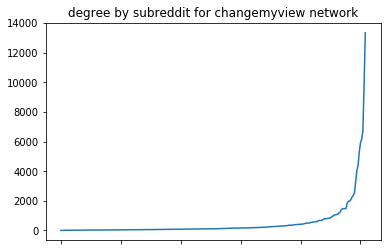

In [167]:
degrees=mat_df.sum().sort_values()
degrees.plot()
plt.title(f'degree by subreddit for {subreddit} network');

In [168]:
degrees.describe()

count      255.000000
mean       503.694118
std       1362.017196
min          0.000000
25%         51.000000
50%        107.000000
75%        347.500000
max      13349.000000
dtype: float64

In [171]:
from scipy.spatial import distance
from scipy.cluster import hierarchy
import seaborn as sns

def get_correlations(mat_df):
    df = mat_df.to_dense().copy()
    return df.corr()
    
def get_linkage(df):
    correlations = df.corr()
    correlations_array = np.asarray(correlations)

    linkage = hierarchy.linkage(
        distance.pdist(correlations_array), method='average', metric='cosine')
    
    return linkage

correlations = mat_df.corr()
linkage = get_linkage(mat_df)
sns.clustermap(correlations, row_linkage=linkage, col_linkage=linkage, method="average",
               figsize=(13, 13), cmap="YlGnBu");

TypeError: values must be SparseArray

In [150]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
%matplotlib inline

def plot_dendogram(mat_df, max_d=False):
    linkage = get_linkage(mat_df)
    
    fig = plt.figure(figsize=(10, 15))
    dn = dendrogram(linkage, truncate_mode='lastp', orientation='left',
                    show_leaf_counts=False,show_contracted=True)
    if max_d:
        plt.axvline(x=max_d, c='k')
    plt.show()
    
plot_dendogram(mat_df)

ValueError: The condensed distance matrix must contain only finite values.

In [151]:
from scipy.cluster.hierarchy import fcluster

def get_cluster_dict(mat_df, max_df):
    linkage = get_linkage(mat_df)
    clusters = fcluster(linkage, max_df, criterion='distance')

    cluster_dict = {}
    for node_num in range((len(clusters))):
        node_label = node_ids[node_num]
        cluster_num = clusters[node_num]
        cluster_dict[node_label] = cluster_num
        
    return cluster_dict


cluster_dict = get_cluster_dict(mat_df, 2)
plt.hist(cluster_dict.values());

ValueError: The condensed distance matrix must contain only finite values.

In [161]:
cmap = sns.choose_cubehelix_palette(as_cmap=True)

A Jupyter Widget

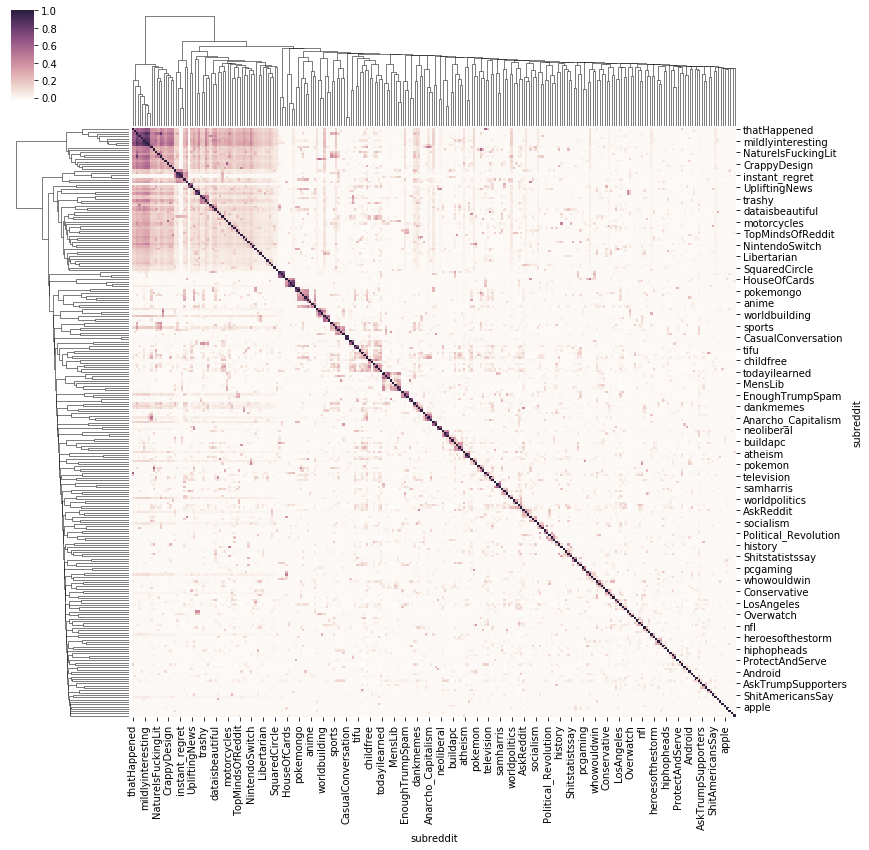

In [163]:
aff_mat = subset.pivot_table(columns='subreddit',index='author',values='weight')

df = aff_mat.to_dense().fillna(0).copy()
df[df<10]=0
correlations = df.corr()
correlations_array = np.asarray(df.corr())

row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average', metric='cosine')

col_linkage = hierarchy.linkage(
    distance.pdist(correlations_array.T), method='average', metric='cosine')
sns.clustermap(correlations, row_linkage=row_linkage, col_linkage=col_linkage, method="average",
               figsize=(13, 13), cmap=cmap);

In [96]:
cluster_df = pd.DataFrame.from_dict(cluster_dict, orient='index')
cluster_df.colums = ['cluster']
cluster_df['cluster']

1    236
2     19
Name: cluster, dtype: int64

In [97]:
cluster_df[cluster_df['cluster']==2]

,cluster
de,2
Advice,2
MensLib,2
pokemon,2
AskOuija,2
nintendo,2
boardgames,2
AskALiberal,2
AskFeminists,2
changemyview,2


### network visuals

In [98]:
import networkx as nx
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [103]:
G = nx.Graph(sub_net)

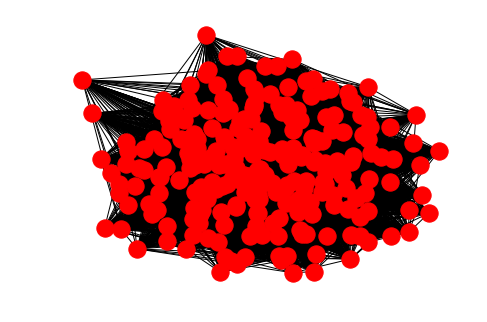

In [106]:
plt.figure(figsize=(6,4));
nx.draw(G)

In [115]:
for ix,deg in dict(G.degree()).items():
    G.node[ix]['degree'] = int(deg)
    G.node[ix]['parity'] = int((1-deg%2))

In [116]:
from networkx.readwrite import json_graph
data = json_graph.node_link_data(G)
with open('graph.json', 'w') as f:
    json.dump(data, f, indent=4)

TypeError: Object of type 'int32' is not JSON serializable

In [121]:
edges = mat_df.unstack()

In [122]:
edges.shape

(65025,)

In [123]:
edges.describe()

count    65025.000000
mean         3.590373
std         12.493469
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        774.000000
dtype: float64

In [125]:
for k, v in mat_df.iteritems():
    v[v < 0] = 0

//anaconda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


TypeError: cannot convert int to an sparseblock